In [7]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

#### Plot layout
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette("plasma")
plt.rcParams["figure.dpi"] = 120
plt.rcParams['text.usetex'] = True

#### Axis labels
labels = dict(doc=r"Degree of Cure $X \; [-]$",
             Tg=r"Glass Transition Temperature $T_g \; [^\circ C]$",
             temp=r"Temperature $\vartheta \; [^\circ C]$",
             X_max=r"Max. Degree of Cure $X_{\max} \; [-]$",
             time=r"Time $t \; [s]$")

#### Constants
kelvin = 273.15
R = 8.314472

# TTT Diagram (Time Temperature Transition) of RTM6

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2019_

Use the models from lesson 01 to build a TTT diagram for RTM6

<img src="./figures/TTT_Diagramm_compiled.jpg" width="500"/>

# RTM6 Cure Modeling

Models and parameters taken from Hein et al, DLR:

> Exner, Wibke; Hein, Robert; Mahrholz, Thorsten; Wierach, Peter; Monner, Hans Peter; Sinapius, Michael (2018): _Impact of nanoparticles on the process-induced distortions of carbon fiber reinforced plastics. An experimental and simulative approach._ In: J. Appl. Polym. Sci. 43 (14), S. 47031. DOI: https://doi.org/10.1002/app.47031

In [8]:
def calc_Tg(X, model_parameters):
    """Calculate current glass transition temperature"""
    Tg0 = model_parameters["Tg0"]
    Tg8 = model_parameters["Tg8"]
    l = model_parameters["lam"]
    return Tg0 + ((Tg8-Tg0)*l*X)/(1-(1-l)*X)
def arrhenius(A, E, T):
    """Calculate Arrhenius factor k"""
    return A*np.exp(-E / R / T)
def arrhenius_facors(temp, model_parameters):
    """Calculate both arrhenius factos k1 and k2 for temperature temp and the model"""
    T = temp + kelvin
    A1 = model_parameters["A1"]
    EA1 = model_parameters["EA1"]
    A2 = model_parameters["A2"]
    EA2 = model_parameters["EA2"]
    return arrhenius(A1, EA1, T), arrhenius(A2, EA2, T)
def calc_X_max(temp, model_parameters): 
    """Calculate maximum attainable degree of cure depending on cure temperature"""
    a = model_parameters["a"]
    b = model_parameters["b"]
    return 1/(1+np.exp(-temp*a+b))
def interpol_tempcycle(t, cycle):
    """Return temperature at time t in cycle by linear interpolation"""
    return np.interp(t, cycle[:,0], cycle[:,1])
def reaction_model(X, t, cycle, model_parameters):  
    """Calculate reaction rate, input function for numerical integration"""
    temp = interpol_tempcycle(t, cycle)
    k1, k2 = arrhenius_facors(temp, model_parameters)
    max_X = calc_X_max(temp, model_parameters)
    m = model_parameters["m"]
    l = model_parameters["l"]
    n = model_parameters["n"]
    d_X = np.max([0, max_X - X])
    return k1 * d_X**l + k2 * X**m * d_X**n

Hein_2018 = dict(Tg0=-16.8, Tg8=225, lam=.543,    # DiBenedetto
                a=.04, b=3.93,                    # X_max
                A1=np.exp(11.149), EA1=75549,     # Cure model parameters
                A2=np.exp(8.762), EA2=50911, 
                l=.489, m=1.549, n=2.179,
                Xgel=.58
                )
#### Constants
kelvin = 273.15
R = 8.314472

## Build TTT diagram from Model

In [9]:
def find_closest_entry(arr, value):
    """Find in (1D) array arr the index of the element closest to value"""
    idx = np.argmin(np.abs(arr - value))
    if (value < np.min(arr)) or (value > np.max(arr)):
        idx = None
    return idx        

### Example: Find all points for one temperature

<IPython.core.display.Javascript object>


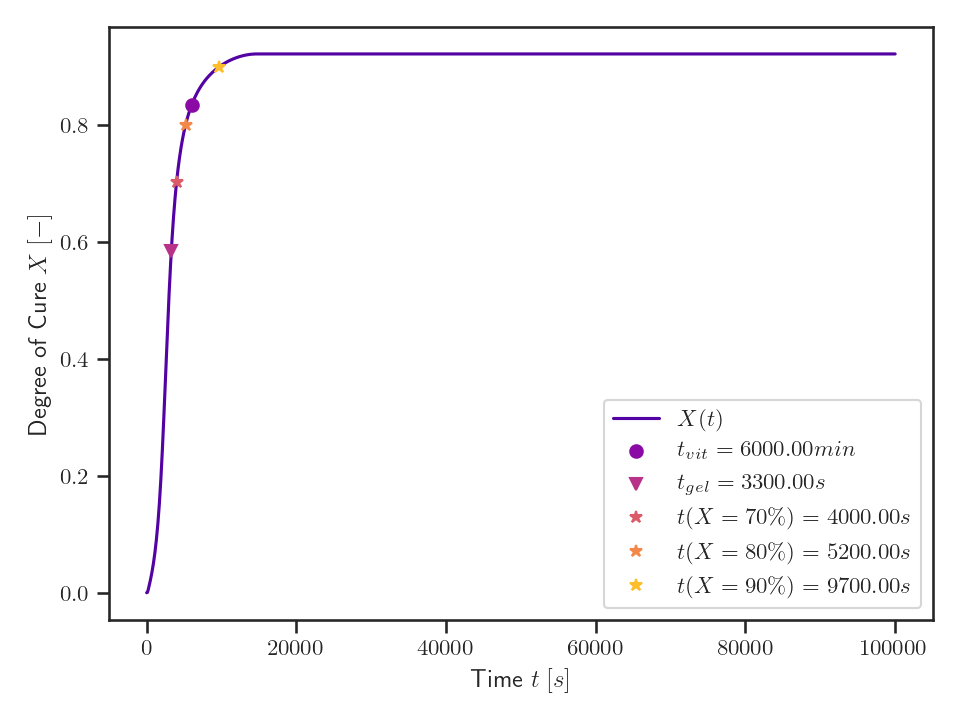

no transition to X=99.000000 % found!


In [10]:
### Modeling Parameters
# Cure temperature [°C]
T = 160
# Degree of Cure at beginning
X0 = 0
# end time of simulation [s]
t_max = 1e5
# Number of time steps
N = 1001
# evenly spaced time vector for output
t = np.linspace(0, t_max, N)
# Make an array for temperature of same length
T_array = np.ones(N) * T
# Find transition points of these degrees of cure
X_iso = [.7, .8, .9, .99]

#### Solve Partial Equation of Cure Reaction at time steps t
X = odeint(reaction_model, X0, t, args=(np.array([t, T_array]), Hein_2018))
X = np.ravel(X)

plt.figure()
plt.plot(t, X, label=r"$X(t)$")

# Find point where current glass transition temperature is equal to cure temperature
Tg = calc_Tg(X, Hein_2018)
i_vitrification = find_closest_entry(Tg, T)
if i_vitrification is None:
    t_vitrification = np.nan
else:
    t_vitrification = t[i_vitrification]
    plt.plot(t_vitrification, X[i_vitrification], marker="o", ls="none", 
             label=r"$t_{vit} = %.2f min$" %(t_vitrification))

# Find gellation point
Xgel = Hein_2018["Xgel"]
i_gel = find_closest_entry(X, Xgel)
if i_gel is None:
    t_gel = np.nan
else:
    t_gel = t[i_gel]
    plt.plot(t_gel, X[i_gel], marker="v", ls="none", 
             label=r"$t_{gel} = %.2f s$" %(t_gel))

for _x in X_iso:
    i_x = find_closest_entry(X, _x)
    if i_x is None:
        t_x = np.nan
        print("no transition to X=%f %% found!" %(_x*100))
    else:
        t_x = t[i_x]
        plt.plot(t_x, X[i_x], marker="*", ls="none", 
                 label=r"$t(X=%d \%%) = %.2f s$" %(_x*100, t_x))
    
plt.xlabel(labels["time"])
plt.ylabel(labels["doc"])
plt.legend()
plt.tight_layout();

<IPython.core.display.Javascript object>


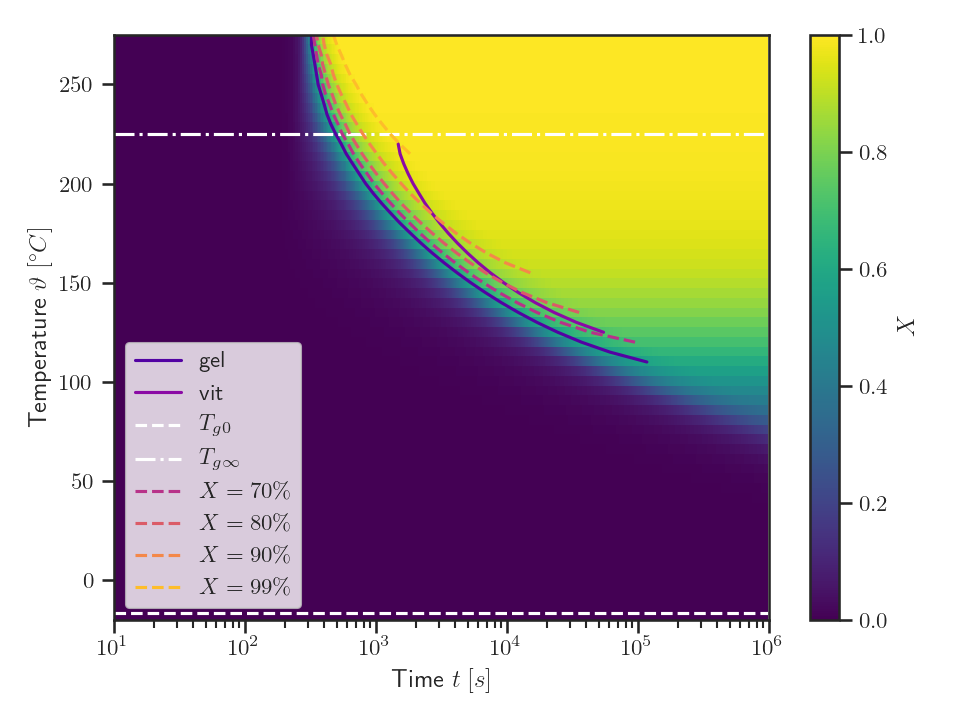

In [11]:
# Cure temperature [°C]
temperatures = range(-20, 280, 5)

# Degree of Cure at beginning
X0 = 0
# end time of simulation [s]
t_max = 1e6
# Number of time steps
N = 100001
# evenly spaced time vector for output
t = np.linspace(0, t_max, N)

# allocate result arrays
N_temperatures = len(temperatures)
t_gel = np.zeros(N_temperatures)
t_vit = np.zeros(N_temperatures)
t_x_iso = np.zeros((N_temperatures, len(X_iso)))
X_array = np.zeros((N, N_temperatures))


for i, T in enumerate(temperatures):
    # Make an array for temperature of same length
    T_array = np.ones(N) * T

    #### Solve Partial Equation of Cure Reaction at time steps t
    X = odeint(reaction_model, X0, t, args=(np.array([t, T_array]), Hein_2018))
    X = np.ravel(X)
    X_array[:, i] = X

    # Find point where current glass transition temperature is equal to cure temperature
    Tg = calc_Tg(X, Hein_2018)
    i_vitrification = find_closest_entry(Tg, T)
    if i_vitrification is None:
        t_vit[i] = np.nan
    else:
        t_vit[i] = t[i_vitrification]

    # Find gellation point
    Xgel = Hein_2018["Xgel"]
    i_gel = find_closest_entry(X, Xgel)
    if i_gel is None:
        t_gel[i] = np.nan
    else:
        t_gel[i] = t[i_gel]


    for j, _x in enumerate(X_iso):
        i_x = find_closest_entry(X, _x)
        if i_x is None:
            t_x_iso[i, j] = np.nan
        else:
            t_x_iso[i, j] = t[i_x]
            
plt.figure()
p = plt.imshow(X_array.T, cmap="viridis", aspect="auto", vmin=0, vmax=1, origin="lower", 
              extent=[t[0], t[-1], temperatures[0], temperatures[-1]])
plt.colorbar(p, label=r"$X$")
plt.plot(t_gel, temperatures, label="gel")
plt.plot(t_vit, temperatures, label="vit")
plt.axhline(Hein_2018["Tg0"], label=r"$T_{g0}$", color="white", ls="--")
plt.axhline(Hein_2018["Tg8"], label=r"$T_{g \infty}$", color="white", ls="-.")
for j, _x in enumerate(X_iso):
    i_x = find_closest_entry(X, _x)
    plt.plot(t_x_iso[:, j], temperatures, ls="--", 
             label=r"$X=%d \%%$" %(_x*100))

plt.xlabel(labels["time"])
plt.ylabel(labels["temp"])
plt.legend()
plt.xscale("log")
plt.xlim((t[1], t[-1]))
plt.tight_layout();

<IPython.core.display.Javascript object>


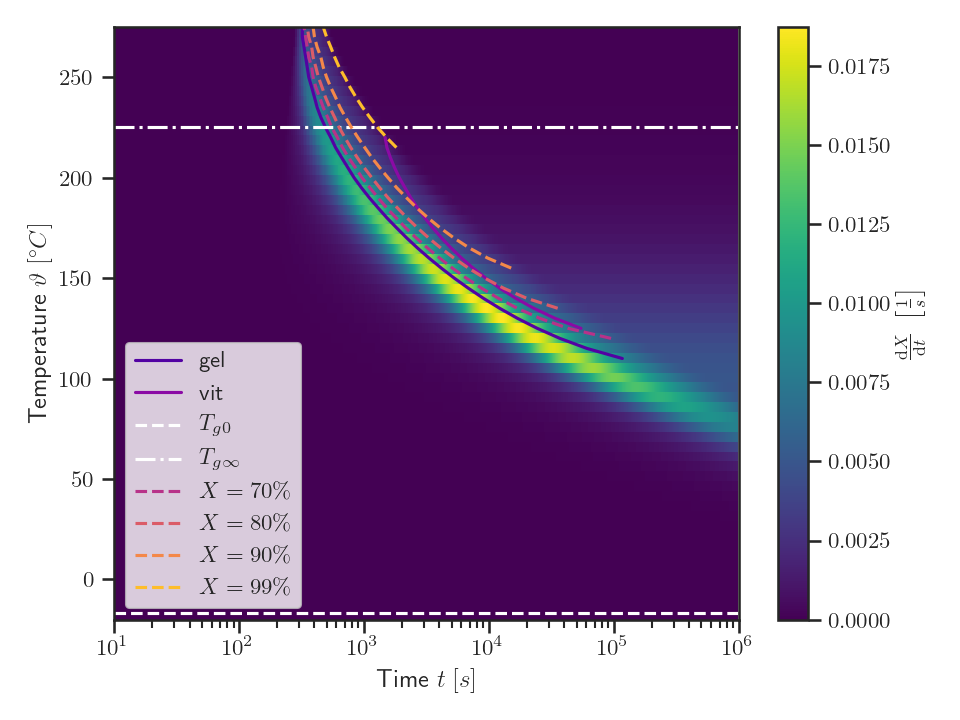

In [12]:
X_GRAD = np.gradient(X_array, axis=1)/(t[1] - t[0])

plt.figure()
p = plt.imshow(X_GRAD.T, cmap="viridis", aspect="auto", vmin=0, origin="lower", 
              extent=[t[0], t[-1], temperatures[0], temperatures[-1]])
plt.colorbar(p, label=r"$\frac{\mathrm{d} X}{\mathrm{d} t} \; \left[ \frac{1}{s} \right]$")
plt.plot(t_gel, temperatures, label="gel")
plt.plot(t_vit, temperatures, label="vit")
plt.axhline(Hein_2018["Tg0"], label=r"$T_{g0}$", color="white", ls="--")
plt.axhline(Hein_2018["Tg8"], label=r"$T_{g \infty}$", color="white", ls="-.")
for j, _x in enumerate(X_iso):
    i_x = find_closest_entry(X, _x)
    plt.plot(t_x_iso[:, j], temperatures, ls="--", 
             label=r"$X=%d \%%$" %(_x*100))

plt.xlabel(labels["time"])
plt.ylabel(labels["temp"])
plt.legend()
plt.xscale("log")
plt.xlim((t[1], t[-1]))
plt.tight_layout();